https://www.kaggle.com/competitions/otto-recommender-system/discussion/365358

https://github.com/AmazingDD/MF-pytorch

https://www.asc.ohio-state.edu/statistics/dmsl//Koren_2009.pdf

https://www.ethanrosenthal.com/2017/06/20/matrix-factorization-in-pytorch/

## Original introduction by Radek

A co-visitation matrix is essentially an "analog" approximation to matrix factorization! I talk a bit more about this idea here: [💡 What is the co-visitation matrix, really?](https://www.kaggle.com/competitions/otto-recommender-system/discussion/365358).

But matrix factorization has a lot of advantages as compared to co-visitation matrices. First of all, it can make better use of data -- it operates on the notion of similarity between categories. We can construct a more powerful representation if our model understands that aid `1` is similar to aid `142` as opposed to it treating each aid as an atomic entity (this is the jump from unigram/bigram/trigram models to word2vec in NLP).

Let us thus train a matrix factorization model and replace the co-visitation matrices with it!

Now, I don't expect that the first version of the model will be particularly well tuned. There has already been a lot of work put into co-visitation matrices and in the later versions we work off 3 different matrices, one for each category of actions! A similar progression can and will happen with matrix factorization 🙂 This notebook hopefully will enable us to jumpstart this type of exploration 🙂

To streamline the work, we will use data in `parquet` format. (Here is the notebook [💡 [Howto] Full dataset as parquet/csv files](https://www.kaggle.com/code/radek1/howto-full-dataset-as-parquet-csv-files) and here is [the most up-to-date version of the dataset](https://www.kaggle.com/datasets/radek1/otto-full-optimized-memory-footprint), no need for dealing with `jasonl` files and the associated mess any longer! Please upvote if you find this useful!)

For data processing we will use [polars](https://www.pola.rs/). `Polars` has a much smaller memory footprint than `pandas` and is quite fast. Plus it has really clean, intuitive API.

Let's get to work! 🙂


## Other resources you might find useful:

* [💡 Training an XGBoost Ranker on the GPU with Merlin Models 🔥🔥🔥](https://www.kaggle.com/competitions/otto-recommender-system/discussion/368848)
* [How to train a Word2Vec model 🚀🚀🚀](https://www.kaggle.com/competitions/otto-recommender-system/discussion/368384)
* [💡 Can you beat static rules with a ranker model without additional features?](https://www.kaggle.com/competitions/otto-recommender-system/discussion/366474)
* [🐘 the elephant in the room -- high cardinality of targets and what to do about this](https://www.kaggle.com/competitions/otto-recommender-system/discussion/364722)
* [📖 What are some good resources to learn about how gradient-boosted tree ranking models work?](https://www.kaggle.com/competitions/otto-recommender-system/discussion/366477)
* [💡How to ensemble predictions -- a key component to every strong solution 🏅](https://www.kaggle.com/competitions/otto-recommender-system/discussion/368747)
* [from zero to 60 in 2 seconds or less 🏎️🚓🚓🚓](https://www.kaggle.com/competitions/otto-recommender-system/discussion/367058)
* [💡What is a good initial goal in the competition? How to improve beyond it? 📈](https://www.kaggle.com/competitions/otto-recommender-system/discussion/368685)
* [💡How to improve the results of your Approximate Nearest Neighbor search! (annoy)](https://www.kaggle.com/competitions/otto-recommender-system/discussion/368385)
* [📅 Dataset for local validation created using organizer's repository (parquet files)](https://www.kaggle.com/competitions/otto-recommender-system/discussion/364534)


In [1]:
from os import listdir
#from tqdm import tqdm

In [2]:
from google.colab import drive

if "drive" not in listdir():
    drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print(listdir())
print(listdir("drive/Shareddrives/wsm_final/final_project/dataset/parquet/"))

['.config', 'drive', 'sample_data']
['train.parquet', 'test.parquet', 'archive.zip', 'train_pairs.parquet', 'valid_pairs.parquet']


In [4]:
path = "drive/Shareddrives/wsm_final/final_project/dataset/"

#  installation

In [5]:
!pip install cudf-cu11 dask-cudf-cu11 --extra-index-url=https://pypi.ngc.nvidia.com
!pip install cuml-cu11 --extra-index-url=https://pypi.ngc.nvidia.com
!pip install cugraph-cu11 --extra-index-url=https://pypi.ngc.nvidia.com

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.8/442.8 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.6/453.6 KB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 923.4/923.4 KB 40.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protob

We will have up to `1855602` -- that is a lot! But our matrix factorization model will be able to handle this.


Oh dear, that took forever! Mind you, were are not doing anything here, apart from iterating over the dataset for a single epoch (and that is without validation!).

The reason this is taking so long is that indexing into the the arrays and collating results into batches is very computationally expensive.

There are ways to work around this but they require writing a lot of code (you could use the iterable-style dataset). And still our solution wouldn't be particularly well optimized.

Let us do something else instead!

We will use a brand new [Merlin Dataloader](https://github.com/NVIDIA-Merlin/dataloader). It is a library that my team launched just a couple of days ago 🙂

Now this library shines when you have a GPU, which is what you generally want when training DL models. But, alas, Kaggle gives you only 13 GB of RAM on a kernel with a GPU, and that wouldn't allow us to process our dataset!

Let's see how far we can get with CPU only.

In [6]:
!pip install merlin-dataloader==0.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 KB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.1/112.1 KB 13.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 KB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... don

# data preparation

In [7]:
from merlin.loader.torch import Loader

We can read data directly from the disk -- even better!

Let's write our datasets to disk.

In [17]:
!pip install polars
import polars
polars.read_parquet(path + 'parquet/train_pairs.parquet')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 69.7 MB/s eta 0:00:00


aid,aid_next
i32,i32
1517085,1563459
1563459,1309446
1309446,16246
16246,1781822
1781822,1152674
1152674,1649869
1649869,461689
461689,305831
305831,461689


In [8]:
from merlin.loader.torch import Loader 
from merlin.io import Dataset

train_ds = Dataset(path + 'parquet/train_pairs.parquet')
batch_size = 65536
train_dl_merlin = Loader(train_ds, batch_size, True)

In [19]:
len(train_dl_merlin)

3038

In [30]:
for batch in train_dl_merlin:
    print(len(batch))
    break

2


In [17]:
for epoch in range(1):
    for batch, _ in train_dl_merlin:
        #print(batch)
        #break
        aid1, aid2 = batch['aid'], batch['aid_next']
        #print(aid1)
        print(aid2)
        break

tensor([[1554822],
        [1245849],
        [ 557191],
        ...,
        [1551546],
        [ 308635],
        [1020797]], device='cuda:0', dtype=torch.int32)


That is much better 🙂. Let's train our matrix factorization model!

https://www.ethanrosenthal.com/2017/06/20/matrix-factorization-in-pytorch/

In [9]:
import torch
from torch import nn


class MatrixFactorization(nn.Module):
    def __init__(self, n_aids, n_factors):
        super().__init__()
        self.aid_factors = nn.Embedding(n_aids, n_factors, sparse=True)
        
    def forward(self, aid1, aid2):
        aid1 = self.aid_factors(aid1)
        aid2 = self.aid_factors(aid2)
        return (aid1 * aid2).sum(dim=1)


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

valid_ds = Dataset(path + 'parquet/valid_pairs.parquet')
valid_dl_merlin = Loader(valid_ds, batch_size, True)

In [10]:
from torch.optim import SparseAdam

num_epochs = 20
lr = 0.01
cardinality_aids = 1855602 # number of aid

model = MatrixFactorization(cardinality_aids+1, 32+32+32)
optimizer = SparseAdam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

In [11]:
%%time

training_loss = []
training_accuracy = []

model.to('cuda')
for epoch in range(num_epochs):
    for batch, _ in train_dl_merlin:
        model.train()
        losses = AverageMeter('Loss', ':.4e')
            
        aid1, aid2 = batch['aid'], batch['aid_next']
        aid1 = aid1.to('cuda')
        aid2 = aid2.to('cuda')
        output_pos = model(aid1, aid2)
        output_neg = model(aid1, aid2[torch.randperm(aid2.shape[0])])
        
        output = torch.cat([output_pos, output_neg])
        targets = torch.cat([torch.ones_like(output_pos), torch.zeros_like(output_pos)])
        loss = criterion(output, targets)
        losses.update(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.eval()
    
    with torch.no_grad():
        accuracy = AverageMeter('accuracy')
        for batch, _ in valid_dl_merlin:
            aid1, aid2 = batch['aid'], batch['aid_next']
            output_pos = model(aid1, aid2)
            output_neg = model(aid1, aid2[torch.randperm(aid2.shape[0])])
            accuracy_batch = torch.cat([output_pos.sigmoid() > 0.5, output_neg.sigmoid() < 0.5]).float().mean()
            accuracy.update(accuracy_batch, aid1.shape[0])
            
    print(f'epoch{epoch+1:02d}: * TrainLoss {losses.avg:.3f}  * Accuracy {accuracy.avg:.3f}')
    training_loss.append(losses.avg)
    training_accuracy.append(accuracy.avg)

print("DONE training!")

epoch01: * TrainLoss 0.628  * Accuracy 0.661
epoch02: * TrainLoss 0.608  * Accuracy 0.690
epoch03: * TrainLoss 0.599  * Accuracy 0.702
epoch04: * TrainLoss 0.595  * Accuracy 0.709
epoch05: * TrainLoss 0.592  * Accuracy 0.713
epoch06: * TrainLoss 0.591  * Accuracy 0.716
epoch07: * TrainLoss 0.589  * Accuracy 0.718
epoch08: * TrainLoss 0.589  * Accuracy 0.720
epoch09: * TrainLoss 0.587  * Accuracy 0.721
epoch10: * TrainLoss 0.588  * Accuracy 0.722
epoch11: * TrainLoss 0.586  * Accuracy 0.723
epoch12: * TrainLoss 0.585  * Accuracy 0.723
epoch13: * TrainLoss 0.585  * Accuracy 0.724
epoch14: * TrainLoss 0.585  * Accuracy 0.724
epoch15: * TrainLoss 0.584  * Accuracy 0.725
epoch16: * TrainLoss 0.585  * Accuracy 0.725
epoch17: * TrainLoss 0.585  * Accuracy 0.725
epoch18: * TrainLoss 0.585  * Accuracy 0.726
epoch19: * TrainLoss 0.584  * Accuracy 0.726
epoch20: * TrainLoss 0.584  * Accuracy 0.726
DONE training!
CPU times: user 24min 57s, sys: 3min 42s, total: 28min 39s
Wall time: 29min 16s


In [12]:
num_epochs = 20
lr = 0.01
cardinality_aids = 1855602 # number of aid

model = MatrixFactorization(cardinality_aids+1, 32)
optimizer = SparseAdam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

In [13]:
%%time

model.to('cuda')
for epoch in range(num_epochs):
    for batch, _ in train_dl_merlin:
        model.train()
        losses = AverageMeter('Loss', ':.4e')
            
        aid1, aid2 = batch['aid'], batch['aid_next']
        aid1 = aid1.to('cuda')
        aid2 = aid2.to('cuda')
        output_pos = model(aid1, aid2)
        output_neg = model(aid1, aid2[torch.randperm(aid2.shape[0])])
        
        output = torch.cat([output_pos, output_neg])
        targets = torch.cat([torch.ones_like(output_pos), torch.zeros_like(output_pos)])
        loss = criterion(output, targets)
        losses.update(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.eval()
    
    with torch.no_grad():
        accuracy = AverageMeter('accuracy')
        for batch, _ in valid_dl_merlin:
            aid1, aid2 = batch['aid'], batch['aid_next']
            output_pos = model(aid1, aid2)
            output_neg = model(aid1, aid2[torch.randperm(aid2.shape[0])])
            accuracy_batch = torch.cat([output_pos.sigmoid() > 0.5, output_neg.sigmoid() < 0.5]).float().mean()
            accuracy.update(accuracy_batch, aid1.shape[0])
            
    print(f'epoch{epoch+1:02d}: * TrainLoss {losses.avg:.3f}  * Accuracy {accuracy.avg:.3f}')
    training_loss.append(losses.avg)
    training_accuracy.append(accuracy.avg)

print("DONE training!")

epoch01: * TrainLoss 0.621  * Accuracy 0.672
epoch02: * TrainLoss 0.602  * Accuracy 0.699
epoch03: * TrainLoss 0.595  * Accuracy 0.709
epoch04: * TrainLoss 0.591  * Accuracy 0.715
epoch05: * TrainLoss 0.589  * Accuracy 0.718
epoch06: * TrainLoss 0.588  * Accuracy 0.721
epoch07: * TrainLoss 0.586  * Accuracy 0.723
epoch08: * TrainLoss 0.585  * Accuracy 0.724
epoch09: * TrainLoss 0.586  * Accuracy 0.725
epoch10: * TrainLoss 0.586  * Accuracy 0.725
epoch11: * TrainLoss 0.584  * Accuracy 0.726
epoch12: * TrainLoss 0.583  * Accuracy 0.726
epoch13: * TrainLoss 0.584  * Accuracy 0.726
epoch14: * TrainLoss 0.584  * Accuracy 0.727
epoch15: * TrainLoss 0.583  * Accuracy 0.727
epoch16: * TrainLoss 0.584  * Accuracy 0.727
epoch17: * TrainLoss 0.583  * Accuracy 0.728
epoch18: * TrainLoss 0.584  * Accuracy 0.728
epoch19: * TrainLoss 0.584  * Accuracy 0.728
epoch20: * TrainLoss 0.583  * Accuracy 0.728
DONE training!
CPU times: user 10min 34s, sys: 3min 26s, total: 14min 1s
Wall time: 14min 20s


In [14]:
import matplotlib.pyplot as plt

In [15]:
training_accuracy = [float(f'{acc:.3f}') for acc in training_accuracy]
training_loss = [float(f'{loss:.3f}') for loss in training_loss]

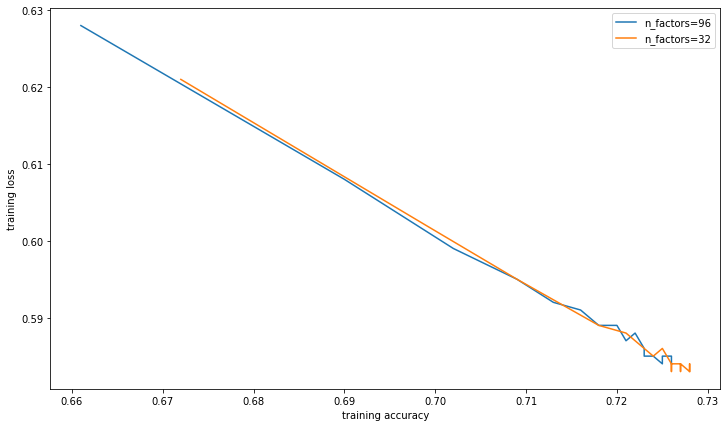

In [19]:
plt.figure(figsize=(12, 7))
plt.plot(training_accuracy[:20], training_loss[:20], label="n_factors=96")
plt.plot(training_accuracy[20:], training_loss[20:], label="n_factors=32")
plt.xlabel("training accuracy")
plt.ylabel("training loss")
plt.legend()
plt.draw()

This code ran about 60x faster than the cpu code form Radek's notebook. And we have not tuned the batch size! Using GPU larger batch size is possible which would reduce the running time further.

Let's grab the embeddings!

In [ ]:
embeddings = model.aid_factors.weight.detach().cpu().numpy()

In [ ]:
embeddings

And construct create the index for approximate nearest neighbor search. We will use cuml for that.

In [ ]:
from cuml.neighbors import NearestNeighbors

We will compute 21 nearest neighbors as in Radek's notebook. 

In [ ]:
%%time

knn = NearestNeighbors(n_neighbors=21, metric='euclidean')
knn.fit(embeddings)

CPU times: user 54 ms, sys: 109 ms, total: 163 ms
Wall time: 165 ms


NearestNeighbors()

Now for any `aid`, we can find its nearest neighbor! cuml let you do this in parallel for all input at once.

In [ ]:
%%time

_, aid_nns = knn.kneighbors(embeddings)

CPU times: user 3min 17s, sys: 2.87 s, total: 3min 19s
Wall time: 3min 23s


Let's check we get 21 neighbors for each aid:

In [ ]:
aid_nns.shape

(1855603, 21)

We can get rid of the first neigbor directly.

In [ ]:
aid_nns = aid_nns[:, 1:]

Let's create a submission! 🙂

In [ ]:
import pandas as pd
import numpy as np
import cudf

from collections import defaultdict

sample_sub = pd.read_csv("/content/drive/Shareddrives/wsm_final/final_project/dataset/sample_submission.csv")
test = cudf.read_parquet("/content/drive/Shareddrives/wsm_final/final_project/dataset/parquet/test.parquet")

session_types = ['clicks', 'carts', 'orders']
gr = test.reset_index(drop=True).to_pandas().groupby('session')
test_session_AIDs = gr['aid'].apply(list)
test_session_types = gr['type'].apply(list)

labels = []

type_weight_multipliers = {0: 1, 1: 6, 2: 3}
for AIDs, types in zip(test_session_AIDs, test_session_types):
    if len(AIDs) >= 20:
        # if we have enough aids (over equals 20) we don't need to look for candidates! we just use the old logic
        weights=np.logspace(0.1,1,len(AIDs),base=2, endpoint=True)-1
        aids_temp=defaultdict(lambda: 0)
        for aid,w,t in zip(AIDs,weights,types): 
            aids_temp[aid]+= w * type_weight_multipliers[t]
            
        sorted_aids=[k for k, v in sorted(aids_temp.items(), key=lambda item: -item[1])]
        labels.append(sorted_aids[:20])
    else:
        # here we don't have 20 aids to output -- we will use approximate nearest neighbor search and our embeddings
        # to generate candidates!
        AIDs = list(dict.fromkeys(AIDs[::-1]))
        
        # let's grab the most recent aid
        most_recent_aid = AIDs[0]
        
        # and look for some neighbors!
        nns = list(aid_nns[most_recent_aid])
                        
        labels.append((AIDs+nns)[:20])

Let's now pull it all together and write to a file,

In [ ]:
labels_as_strings = [' '.join([str(l) for l in lls]) for lls in labels]

predictions = pd.DataFrame(data={'session_type': test_session_AIDs.index, 'labels': labels_as_strings})

prediction_dfs = []

for st in session_types:
    modified_predictions = predictions.copy()
    modified_predictions.session_type = modified_predictions.session_type.astype('str') + f'_{st}'
    prediction_dfs.append(modified_predictions)

submission = pd.concat(prediction_dfs).reset_index(drop=True)
submission.to_csv("/content/drive/Shareddrives/wsm_final/final_project/dataset/submission.csv", index=False)

And we are done!


**If you like this notebook, please smash the upvote button! Thank you! 😊**

There are many ways in which this can be expanded:
* we can train with larger batch sizes
* we can train for longer
* maybe we would get better results if we were to filter our train data by type?
* should we train only on adjacent aids? maybe we should expand the neighborhood we train on

We can keep asking ourselves many questions like this 🙂 Now we have a framework to start answering them!

Thank you for reading! Happy Kaggling! 🙌

In [ ]:
!zip \
/content/drive/Shareddrives/wsm_final/final_project/dataset/submission.zip \
/content/drive/Shareddrives/wsm_final/final_project/dataset/submission.csv

updating: content/drive/Shareddrives/wsm_final/final_project/dataset/submission.csv (deflated 55%)
